Number of arrivals: 194
Number of departures: 180


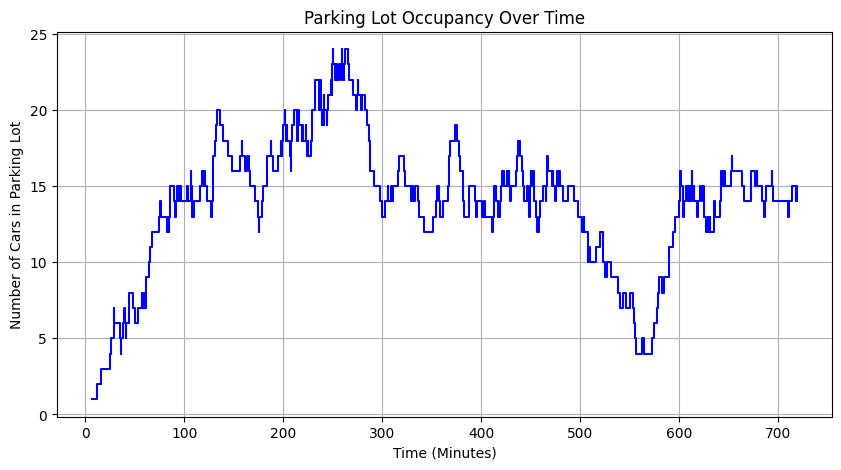

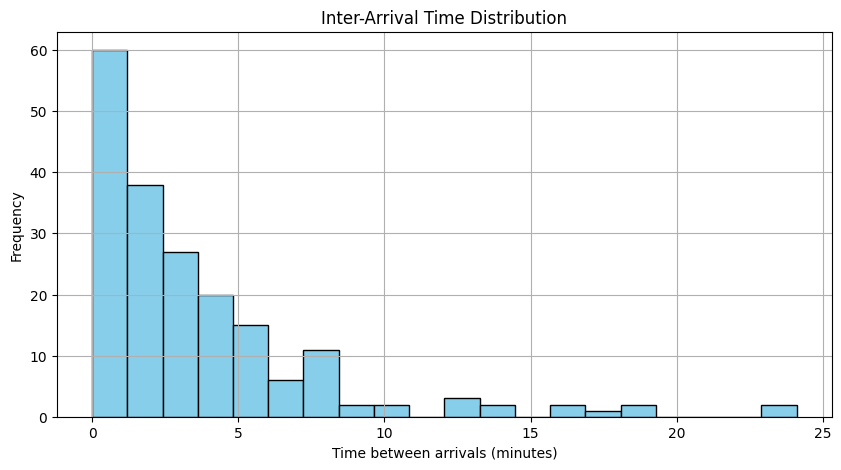

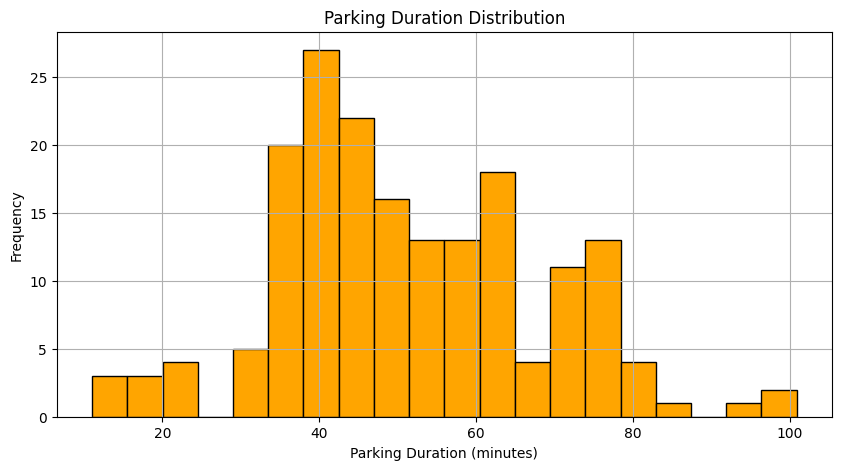

Number of lost customers: 0


In [22]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Parameters
PARKING_SPACES = 100          # Number of parking spaces in the lot
ARRIVAL_RATE = 18 / 60         # Average rate of car arrivals per minute
SIMULATION_TIME = 12 * 60      # Simulating for 24 hours (in minutes)
PARKING_DURATION_MEAN = 59    # Average time a car spends parked (in minutes)

# Data storage
arrival_times = []
departure_times = []
lost_customers = 0
parking_lot_occupancy = []

def car(env, parking_lot, name):
    global lost_customers
    arrival_time = env.now
    if len(parking_lot.queue) + parking_lot.count < PARKING_SPACES:
        arrival_times.append(arrival_time)
        with parking_lot.request() as request:
            yield request
            parking_lot_occupancy.append((env.now, parking_lot.count))
            parking_duration = np.random.exponential(PARKING_DURATION_MEAN)
            yield env.timeout(parking_duration)
            departure_time = env.now
            departure_times.append(departure_time)
            parking_lot_occupancy.append((env.now, parking_lot.count - 1))
    else:
        lost_customers += 1

def car_generator(env, parking_lot):
    while True:
        inter_arrival_time = np.random.exponential(1 / ARRIVAL_RATE)
        yield env.timeout(inter_arrival_time)
        env.process(car(env, parking_lot, f'Car'))

# Set up the environment and the parking lot resource
env = simpy.Environment()
parking_lot = simpy.Resource(env, capacity=PARKING_SPACES)

# Start the car arrival process
env.process(car_generator(env, parking_lot))

# Run the simulation
env.run(until=SIMULATION_TIME)

# Check lengths of arrival_times and departure_times
print(f"Number of arrivals: {len(arrival_times)}")
print(f"Number of departures: {len(departure_times)}")

# Plotting the number of cars in the parking lot over time
times, occupancy = zip(*parking_lot_occupancy)
plt.figure(figsize=(10, 5))
plt.step(times, occupancy, where='post', color='blue')
plt.title('Parking Lot Occupancy Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('Number of Cars in Parking Lot')
plt.grid(True)
plt.show()

# Plot inter-arrival times histogram
inter_arrival_times = [arrival_times[i] - arrival_times[i-1] for i in range(1, len(arrival_times))]
plt.figure(figsize=(10, 5))
plt.hist(inter_arrival_times, bins=20, color='skyblue', edgecolor='black')
plt.title('Inter-Arrival Time Distribution')
plt.xlabel('Time between arrivals (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Ensure the lists are of the same length for parking duration calculation
min_length = min(len(arrival_times), len(departure_times))

# Calculate parking durations only up to the minimum length
parking_durations = [departure_times[i] - arrival_times[i] for i in range(min_length)]

# Plot parking duration histogram
plt.figure(figsize=(10, 5))
plt.hist(parking_durations, bins=20, color='orange', edgecolor='black')
plt.title('Parking Duration Distribution')
plt.xlabel('Parking Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print the number of lost customers
print(f'Number of lost customers: {lost_customers}')
